# Cars classifier

Input for classifier: RGB-image 24x24
Task: recognize images that have car in center of image(center of car must be in square of certain size).

# Loading dataset

In [15]:
import os
import re
import gc
import time
import copy
import json
import math
import copy
import psutil
import builtins
import functools as ft
from PIL import Image
from PIL import ImageDraw
import random
import pathlib
import zipfile
from google.colab import drive
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [16]:
drive.mount('/content/drive')
CARS_DS_ZIPFILE_PATH = '/content/drive/My Drive/cars_ds.zip'
zfile = zipfile.ZipFile(CARS_DS_ZIPFILE_PATH, 'r')

CARS_DS_DIR = pathlib.Path('/content/dataset')
if not CARS_DS_DIR.exists():
    os.mkdir(CARS_DS_DIR)
    zfile.extractall(CARS_DS_DIR)

IMG_FOLDER = CARS_DS_DIR / 'cars_ds' / 'images'
LABELS_PATHS = CARS_DS_DIR / 'cars_ds' / 'labels.json'
with open(LABELS_PATHS) as file:
    labels = json.load(file)['data']

BBOXES = 'boundingboxes'
FILENAME = 'filename'

def get_centers(boxes):
    return list(map(lambda b: ((b[2]+b[0])/2, (b[3]+b[1])/2), boxes))

dataset = []
for label in labels:
    path = str(IMG_FOLDER/label[FILENAME])
    centers = get_centers(label[BBOXES])
    dataset.append((path, centers))

def explore_dataset(dataset):
    all_marks_num = 0
    max_marks_num = 0
    for _, marks in dataset:
        all_marks_num += len(marks)
        max_marks_num = max(max_marks_num, len(marks))
    print('Number of all marked images in dataset: {}'.format(len(dataset)))
    print('Number of bboxes for all images: {}'.format(all_marks_num))
    print('Maximum number of boxes: {}'.format(max_marks_num))
    print('Average number of boxes: {:.2f}'.format(all_marks_num/len(dataset)))
explore_dataset(dataset)

print('\nDataset content:')
print(*dataset[:3], sep='\n')
print('...')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of all marked images in dataset: 3748
Number of bboxes for all images: 10555
Maximum number of boxes: 72
Average number of boxes: 2.82

Dataset content:
('/content/dataset/cars_ds/images/000000000.jpg', [(64.025, 157.87), (15.875, 211.24), (52.230000000000004, 46.845)])
('/content/dataset/cars_ds/images/000000001.jpg', [(64.025, 45.870000000000005), (15.875, 99.24000000000001)])
('/content/dataset/cars_ds/images/000000002.jpg', [(209.83499999999998, 216.685), (219.01999999999998, 126.085)])
...


# Sample preprocessing

In [17]:
OI_W = 224  # original image width and height
FI_W = 24  # fragment image width and height
CENTER_PADDING = 4  # center must not be closer to brink than this value
IN_SHAPE = (FI_W, FI_W, 3)
SQ_SIZE = 4
SQ_TRUE_W = 24

In [18]:
def dist(pt_1, pt_2):
    return math.sqrt((pt_2[0]-pt_1[0])**2 + (pt_2[1]-pt_1[1])**2)

def dist2(pt_1, pt_2):
    return (pt_2[0]-pt_1[0])**2 + (pt_2[1]-pt_1[1])**2

def get_img(path):
    img = Image.open(path)
    img.load()
    return img

def plot_img(img, title=''):
    plt.xticks([])
    plt.yticks([])
    if title:
        plt.title(title)
    plt.imshow(img, cmap=plt.cm.binary)

def find_closest(pt, points):
    sq_dists = list(map(lambda x: dist2(pt, x), points))
    min_idx = np.argmin(sq_dists)
    return (min_idx, points[min_idx])

def find_min_dist(pt, points):
    _, cl_pt = find_closest(pt, points)
    return dist(cl_pt, pt)

def draw_cross(img, center, color='red', radius=5, width=1):
    c, w, r = center, width, radius
    draw = ImageDraw.Draw(img)
    draw.line([c[0]-r, c[1], c[0]+r, c[1]], fill=color, width=w)
    draw.line([c[0], c[1]-r, c[0], c[1]+r], fill=color, width=w)

def draw_crosses(img, centers, color='red', radius=5, width=1):
    for c in centers:
        draw_cross(img, c, color=color, radius=radius, width=width)

def draw_center_square(img, center, color='red', radius=5, width=1):
    center = (int(round(center[0])), int(round(center[1])))
    c, w, r = center, width, radius
    draw = ImageDraw.Draw(img)
    draw.rectangle([c[0]-r, c[1]-r, c[0]+r-1, c[1]+r-1], outline=color, width=w)

def draw_center_squares(img, centers, color='red', radius=5, width=1):
    for c in centers:
        draw_center_square(img, c, color=color, radius=radius, width=width)

def plot_samples(samples):
    num = len(samples)
    FW = 1.5
    COL_NUM = 10
    row_num = (num-1)//COL_NUM+1
    plt.figure(figsize=(FW*COL_NUM, 1.1*FW*row_num))
    for k, (f_img, prob)  in enumerate(samples):
        plt.subplot(row_num, COL_NUM, k+1)
        prob_str = '0' if prob < 0.001 else '{:.2f}'.format(prob)
        t = 'k{} p{}'.format(k, prob_str)
        plot_img(f_img, t)

def create_rotation_xf(rotation=0):
    a = math.radians(rotation)
    return np.array([[math.cos(a), -math.sin(a), 0],
                     [math.sin(a),  math.cos(a), 0],
                     [          0,            0, 1]])

def create_translation_xf(translation):
    tx, ty = translation
    return np.array([[1, 0, tx],
                     [0, 1, ty],
                     [0, 0,  1]])

def create_rotation_around_center(rotation, center_of_rotation):
    cx, cy = center_of_rotation
    tr_fwd = create_translation_xf((-cx, -cy))
    rot = create_rotation_xf(rotation)
    tr_bwd = create_translation_xf((cx, cy))
    return np.matmul(np.matmul(tr_bwd, rot), tr_fwd)

def apply_xf(points, xf):
    # points - list of tuples, xf - np.array(3x3), retval - list of tuples
    res = []
    for pt in points:
        new_pt = np.matmul(xf, np.array([pt[0], pt[1], 1]))
        res.append((new_pt[0], new_pt[1]))
    return res

def mirror_points_left_right(points, img_size):
    pts = copy.deepcopy(points)
    w, _ = img_size
    for i, pt in enumerate(pts):
        pts[i] = (w-pt[0], pt[1])
    return pts

pos=8555, wc=6240, empt=36634
Relative: pos=16.6%, wc=12.1%, empt=71.232%


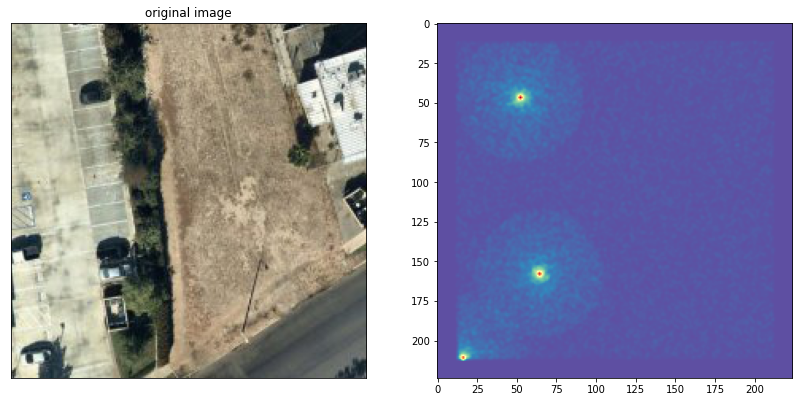

In [19]:
def smooth_matrix(counters_matrix, radius):
    r = radius
    cm = counters_matrix
    h, w = np.shape(cm)
    tmp = np.zeros((h+2*r, w+2*r), dtype=np.float32)
    weight_sum = 0
    for i in range(2*r+1):
        for j in range(2*r+1):
            weight = (2*r+1) - abs(i-r) - abs(j-r) 
            tmp[i:h+i,j:w+j] += counters_matrix * weight
            weight_sum += weight
    tmp = tmp / weight_sum
    counters_matrix[:,:] = tmp[r:h+r,r:w+r]

def draw_distribution_map(f_centers):
    counters = np.zeros((OI_W,OI_W), dtype=np.float32)
    for fc in f_centers:
        counters[int(fc[1]), int(fc[0])] += 1
    smooth_matrix(counters, radius=1)
    maxim = np.max(counters)
    return counters / maxim

def get_random_point_by_normal_ditribution(sigma):
    a = 2* math.pi * random.random()
    r = np.random.uniform(0, sigma)
    # r = np.random.normal(0, sigma)
    x, y = r * math.cos(a), r * math.sin(a)
    return int(round(x)), int(round(y))

def propose_centers(o_img, o_centers, indent, nom_num, nom_car_ratio, sigma):
    """Get array of fragment centers for this image.
    nom_num - nominal number of centers, it corresponds with number of
    fragments, that may be returned for image with 2.8 cars;
    nom_car_ratio - as well, ratio between uniformaly distributed centers and
    normally distributed centers (for cars), relevanted for image with 2.8 cars
    car_sigma - variance of normal distributution
    """
    un_num = int(round(nom_num * (1 - nom_car_ratio)))
    normal_num = int(round(nom_num * nom_car_ratio * len(o_centers) / 2.8))
    if (un_num + normal_num) == 0:
        return None
    assert o_img.width == o_img.height
    result = np.random.randint(indent, o_img.width-indent,
                               size=(un_num + normal_num, 2),
                               dtype=np.int32)
    if len(o_centers) == 0:
        return result
    normal_counter = 0
    safety_counter = 0
    while True:
        car_center_index = random.randrange(len(o_centers))
        cc = o_centers[car_center_index]  # car center
        cx, cy = int(round(cc[0])), int(round(cc[1]))
        rx, ry = get_random_point_by_normal_ditribution(sigma)
        rx, ry = cx + rx, cy + ry
        if ( rx > indent and rx < o_img.width - indent
            and ry > indent and ry < o_img.width-indent):
            result[normal_counter] = rx, ry
            normal_counter += 1
        safety_counter += 1
        if normal_counter >= normal_num or safety_counter > 3 * normal_num:
            break
    return result

def propose_centers_check():
    oi_index = 0
    path, o_centers = dataset[oi_index][0], dataset[oi_index][1]
    o_img = get_img(path)
    NUM = 50000
    f_centers = propose_centers(o_img, o_centers, FI_W/2, NUM, 0.40, 40.0)
    dists = list(map(lambda x: find_min_dist(x, o_centers), f_centers))

    R1 = 1.12 * 0.5*SQ_TRUE_W
    R2 = 0.92 * FI_W
    num_pos, num_wc, num_empt = 0, 0, 0
    for d in dists:
        if d > R2:
            num_empt += 1
        elif d > R1:
            num_wc += 1
        else:
            num_pos += 1

    print( 'pos={}, wc={}, empt={}'.format(num_pos, num_wc, num_empt))
    all_num = len(dists)
    print( 'Relative: pos={:.1f}%, wc={:.1f}%, empt={:.3f}%'.format(
        100*num_pos/all_num, 100*num_wc/all_num, 100*num_empt/all_num))
    dist_map = draw_distribution_map(f_centers)
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plot_img(o_img, 'original image')
    plt.subplot(1,2,2)
    plt.imshow(dist_map, cmap='Spectral_r')
    plt.show()

propose_centers_check()

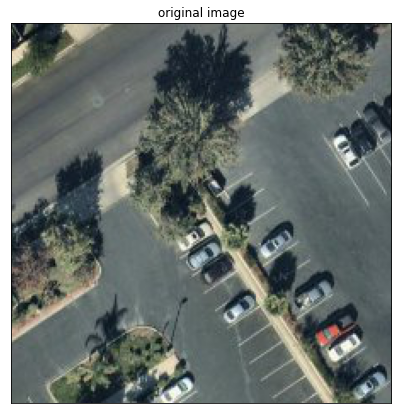

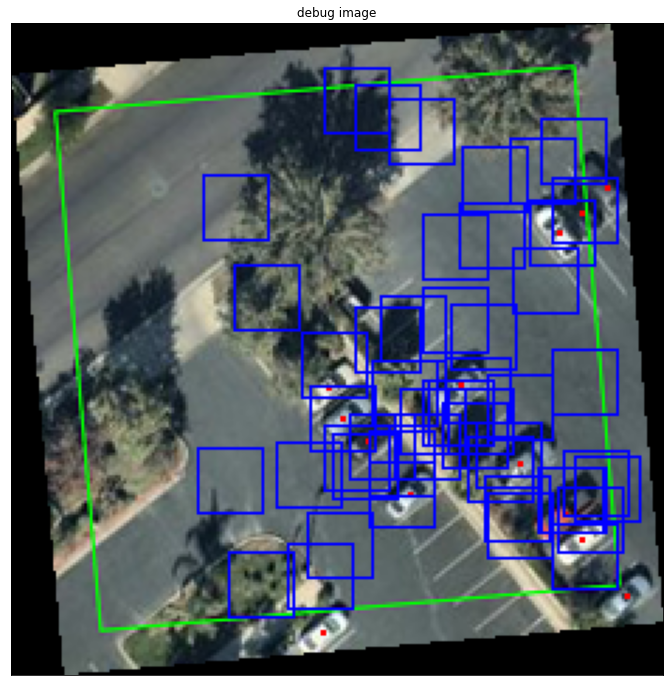

Samples:
Number of positive samples: 19 (38.8%)


In [20]:
def calc_indent(rot):
    a = math.radians(rot % 90 - 45)
    SQRT2 = 1.41421356
    radius = SQRT2 * FI_W/2
    indent = radius* math.cos(a)
    return int(math.ceil(indent))

def calc_prob(fragm_c, closest_c):
    x_diff = abs(closest_c[0] - fragm_c[0])
    y_diff = abs(closest_c[1] - fragm_c[1])
    return 1.0 if x_diff <= SQ_TRUE_W/2 and y_diff <= SQ_TRUE_W/2 else 0.0

def make_samples(rotd_img, o_centers, f_centers):
    samples = []
    for fc in f_centers:
        fc = (int(round(fc[0])),int(round(fc[1])))
        crop_rect = [fc[0]-FI_W/2, fc[1]-FI_W/2, fc[0]+FI_W/2, fc[1]+FI_W/2]
        f_img = rotd_img.crop(crop_rect)
        if len(o_centers) > 0:
            _, closest_center = find_closest(fc, o_centers)
            p = calc_prob(fc, closest_center)
            samples.append((np.array(f_img), p))
        else:
            samples.append((np.array(f_img), 0.))
    return samples

def scale_image(o_img, scale):
    size = (int(round(o_img.width * scale)), int(round(o_img.height * scale)))
    return o_img.resize(size, resample=Image.BICUBIC, reducing_gap=3.0)

def scale_points(points, scale):
    return list(map(lambda pt: (pt[0]*scale, pt[1]*scale), points))

def take_samples(o_img, o_centers, num, nom_car_ratio=0.4, sigma=8., 
                 cert_mirror=None, cert_scale=None, cert_rotation=None,
                 debug=False):
    debug_img = None
    mirr =  bool(random.randrange(0,1)) if cert_mirror is None else cert_mirror    
    if mirr:
        o_img = o_img.transpose(method=Image.FLIP_LEFT_RIGHT)
        o_centers = mirror_points_left_right(o_centers, img.size)

    scale = random.uniform(0.95, 1.05) if cert_scale is None else cert_scale
    if abs(scale - 1) > 0.01:
        o_img = scale_image(o_img, scale)
        o_centers = scale_points(o_centers, scale)

    rotd_img = None
    indent = 0
    rot = random.random()*360 if cert_rotation is None else cert_rotation
    if rot:
        indent = calc_indent(rot)
        rotd_img = o_img.rotate(rot, resample=Image.BICUBIC, expand=True)

    if debug:
        debug_img = copy.deepcopy(o_img)
        draw = ImageDraw.Draw(debug_img)
        draw.rectangle([indent, indent, debug_img.width-indent-1,
                        debug_img.height-indent-1], outline=(0,255,0))
        debug_img = debug_img.rotate(rot, resample=Image.BICUBIC, expand=True)

    f_centers = propose_centers(o_img, o_centers, indent, num,
                                nom_car_ratio, sigma)
    rot_xf = create_rotation_around_center(-rot, (o_img.width/2, o_img.height/2))
    img_center_shift = (rotd_img.width - o_img.width)/2
    trans_xf = create_translation_xf((img_center_shift, img_center_shift))
    o_centers = apply_xf(apply_xf(o_centers, rot_xf), trans_xf)
    f_centers = apply_xf(apply_xf(f_centers, rot_xf), trans_xf)

    samples = make_samples(rotd_img, o_centers, f_centers)
    if debug:
        draw_center_squares(debug_img, o_centers, radius=1, color='red')
        draw_center_squares(debug_img, f_centers, radius=12, color='blue')
        return samples, debug_img
    else:
        return samples

def take_sample_check():
    oi_index = 5

    path, o_centers = dataset[oi_index][0], dataset[oi_index][1]
    o_img = get_img(path)
    plt.figure(figsize=(7,7))
    plot_img(o_img, 'original image')
    plt.show()
    NUM = 20
    s, debug_img = take_samples(o_img, o_centers, NUM, nom_car_ratio=0.4, sigma=35.0,
                     cert_mirror=False, cert_scale=None, cert_rotation=5, debug=True)
    plt.figure(figsize=(12,12))
    plot_img(debug_img, 'debug image')
    plt.show()
    print('Samples:')
    pos_s = list(filter(lambda x: x[1]>0.001, s))
    pos_num = len(pos_s)
    if pos_num:
        print('Number of positive samples: {} ({:.1f}%)'.format(
            pos_num, 100*pos_num/len(s)))
    # plot_samples(s)
    plt.show()

take_sample_check()

In [21]:
# Noise augmentation

def augment_noise_and_color_shift(x, noise_sigma=None, shift_sigma=None):
    x = x.astype(np.int32)
    if noise_sigma:
        noise = np.random.normal(scale=noise_sigma,size=np.shape(x))
        noise = np.around(noise).astype(np.int32, copy=False)
        x += noise

    if shift_sigma:
        shift = np.ndarray(np.shape(x), dtype=np.int32)
        B_COEFF = 2
        brightness_shift = int(round(random.gauss(0, B_COEFF * shift_sigma)))
        for k in range(3):
            h, w, _ = np.shape(x)
            shift_chanel = np.ndarray((h,w), dtype=np.int32)
            rand = int(round(random.gauss(0, shift_sigma)))
            shift_chanel.fill(rand + brightness_shift)
            shift[:,:,k] = shift_chanel
        x += shift
    return np.clip(x, 0, 255)

def noise_augmentation_check():
    oi_index = 5 # 3617
    path, o_centers = dataset[oi_index][0], dataset[oi_index][1]
    o_img = get_img(path)
    x = np.array(o_img, dtype=np.int32)
    IMG_SZ = (30,30)
    CRSX, CRSY = 95,115 # crop shift
    x = x[CRSY:CRSY+IMG_SZ[0], CRSX:CRSX+IMG_SZ[1], :]
    grey_x = np.ndarray((IMG_SZ[0],IMG_SZ[1],3),dtype=np.int32)
    grey_x.fill(128)

    COL_NUM = 10
    IMG_W = 1.5

    plt.figure(figsize=(COL_NUM*IMG_W,6))
    for k in range(COL_NUM):
        sigm = 3 * k + 0
        plt.subplot(1,COL_NUM,1+k)
        noisy_x = copy.deepcopy(grey_x)
        noisy_x = augment_noise_and_color_shift(noisy_x, noise_sigma=sigm)
        t = 'noise='+str(sigm)
        plot_img(noisy_x, title=t)
    plt.show()

    plt.figure(figsize=(COL_NUM*IMG_W,6))
    for k in range(COL_NUM):
        sigm = 3 * k + 0
        plt.subplot(1,COL_NUM,1+k)
        shifted_x = copy.deepcopy(grey_x)
        shifted_x = augment_noise_and_color_shift(shifted_x, shift_sigma=sigm)
        t = 'shift='+str(sigm)
        plot_img(shifted_x, title=t)
    plt.show()

    plt.figure(figsize=(COL_NUM*IMG_W,6))
    for k in range(COL_NUM):
        ns = 3 * k + 0
        # ss = 3 * k + 0
        ss = 5
        plt.subplot(1,COL_NUM,1+k)
        augm_x = copy.deepcopy(x)
        augm_x = augment_noise_and_color_shift(augm_x, noise_sigma=ns,
                                              shift_sigma=ss)
        t = 'n=' + str(ns) + ',s=' + str(ss)
        augm_x = augm_x.astype(np.uint8)
        plot_img(augm_x,title=t)
    plt.show()

# noise_augmentation_check()
# as summary recomended noise_sigma = 8, shift_sigma=5

Check of border augmentation:



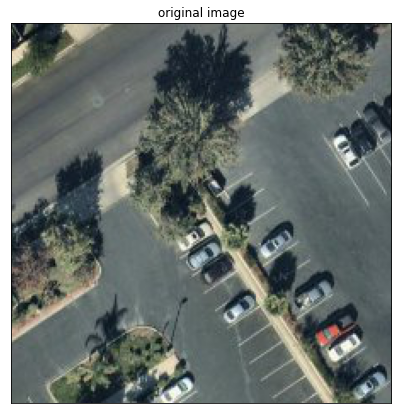

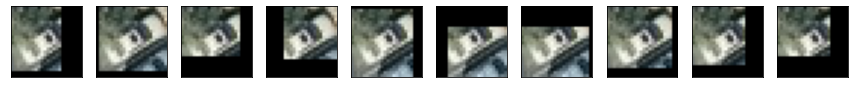

In [22]:
# Border augmentation function try to add borders in corresponding with natural
# probability - 10% (for each side independently). It means 18% for all borders.
ONE_SIDE_BORDER_PROB = 0.10

def augment_border(x, prob=ONE_SIDE_BORDER_PROB):
    tx, ty = 7, 7  # border thickness
    x = copy.deepcopy(x)
    h, w, _ = x.shape
    if random.random() < prob:
        i = random.randrange(-tx, tx)
        (begin, end) = (0, i+1) if i >= 0 else (w+i, w)
        border_arr = np.zeros((h,end-begin,3), dtype=np.int32)
        x[:, begin:end, :] = border_arr
    if random.random() < prob:
        j = random.randrange(-ty, ty)
        (begin, end) = (0, j+1) if j >= 0 else (h+j, h)
        border_arr = np.zeros((end-begin,w,3), dtype=np.int32)
        x[begin:end, :, :] = border_arr
    return x

def augment_border_check():
    print('Check of border augmentation:\n')
    oi_index = 5
    path, o_centers = dataset[oi_index][0], dataset[oi_index][1]
    o_img = get_img(path)
    plt.figure(figsize=(7,7))
    plot_img(o_img, 'original image')
    plt.show()

    shift = (95,115)
    rect = [shift[0], shift[1], shift[0]+FI_W, shift[1]+FI_W]
    fr_img = o_img.crop(rect)
    fr_img = np.array(fr_img)

    NUM = 10
    COL_NUM = 10
    row_num = (NUM - 1) // COL_NUM + 1
    plt.figure(figsize=(COL_NUM * 1.5, row_num * 1.6))
    for k in range(COL_NUM * row_num):
        plt.subplot(row_num, COL_NUM, k+1)
        augm_img = augment_border(fr_img, prob=1.0)
        plot_img(augm_img)
    return plt
augment_border_check().show()

# Batch generation

In [23]:
# Batch provider creates batches from original dataset. It provides uniform
# using of all samples and also a mechanism of data augmentation.

class BatchProvider():
    __ds = None
    __global_counter = 0

    def __init__(self, dataset):
        self.__ds = dataset

    def __get_next_orig_image(self):
        idx = self.__global_counter % len(self.__ds)
        path, o_centers = self.__ds[idx][0], self.__ds[idx][1]
        o_img = Image.open(path)
        o_img.load()
        self.__global_counter += 1
        return o_img, o_centers

    def __augment(self, x, noise_augm, border_augm):
        if noise_augm:
            x = augment_noise_and_color_shift(x, noise_sigma=9, shift_sigma=5)
        if border_augm:
            x = augment_border(x)
        return x

    def generate_batch(self, batch_len,
                       nom_car_ratio=0.4, car_sigma=35.0,
                       noise_augm=False, border_augm=False):
        bx = np.ndarray((batch_len, *IN_SHAPE), dtype=np.int32)
        by = np.ndarray((batch_len, 1), dtype=np.float32)
        counter = 0
        while True:
            o_img, o_centers = self.__get_next_orig_image()
            NUM_FIMG_FROM_OIMG = 40
            rest_num = batch_len - counter
            nom_num = min(NUM_FIMG_FROM_OIMG, rest_num)
            samples = take_samples(o_img, o_centers, nom_num,
                                  nom_car_ratio=nom_car_ratio,
                                  sigma=car_sigma)
            if not samples:
                continue
            if len(samples) > rest_num:
                samples = samples[:rest_num]
            for x, y in samples:
                x = self.__augment(x, noise_augm, border_augm)
                bx[counter], by[counter] = x, y
                counter += 1
            if counter == batch_len:
                break
        return bx, by

def batch_provider_check():
    print('BatchProvider check:')
    BATCH_LEN = 100
    tiny_ds = dataset[:10]
    b_prov = BatchProvider(tiny_ds)
    t0 = time.time()
    bx, by = b_prov.generate_batch(BATCH_LEN, nom_car_ratio=0.4, car_sigma=8.0,
                                   noise_augm=True, border_augm=False)
    print('Time of batch generation ({} samples): {:.2f} seconds'.format(
        BATCH_LEN, time.time()-t0))
    print('bx shape: ', np.shape(bx))
    print('by shape: ', np.shape(by))
    by_pos = list(filter(lambda y: y[0]>0.001, by))
    print('pos num = {} ({:.1f}%)'.format(len(by_pos),100*len(by_pos)/len(by)))
    plt.figure(figsize=(14,100))
    FW = 1.5
    COL_NUM = 10
    row_num = (BATCH_LEN-1)//COL_NUM+1
    plt.figure(figsize=(FW*COL_NUM, 1.1*FW*row_num))
    for k  in range(BATCH_LEN):
        x, y = bx[k], by[k]
        plt.subplot(row_num, COL_NUM, k+1)
        t = 'p={:.3f}'.format(y[0])
        plot_img(x, t)
    return plt
# batch_provider_check()

# Model definition

In [24]:
def create_model_1():
    model = Sequential([layers.experimental.preprocessing.Rescaling(1./255,
                            input_shape=IN_SHAPE),
                        layers.Conv2D(16, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(32, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(64, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Dropout(0.2),
                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

m = create_model_1()
m.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 24, 24, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)         

In [25]:
def find_last_model(models_folder):
    model_list = os.listdir(models_folder)
    model_list = list(map(lambda s: pathlib.Path(s), model_list))
    model_list = list(map(lambda fn: fn.stem, model_list))
    versions = []
    for name in model_list:
        parts = re.split(r'\_+', name)
        if parts[0] == 'model':
            versions.append(int(parts[1]))
    if not versions:
        return ''
    last_version = max(versions)
    last_model = 'model_{}.hdf5'.format(last_version)
    return last_model

def get_incremented_model_version(model_name):
    model_name = str(pathlib.Path(model_name).stem)
    _, version = re.split(r'\_+', model_name)
    return 'model_{}.hdf5'.format(int(version)+1)

def load_or_create_model(models_folder, model_index):
    model = None
    last_model = find_last_model(models_folder)
    if last_model:
        last_model = models_folder / last_model
        model = tf.keras.models.load_model(str(last_model))
        print('Model was loaded from file: {}'.format(last_model.name), '\n')
    else:
        if model_index == 1:
            model = create_model_1()
        elif model_index == 2:
            model = create_model_2()
        elif model_index == 3:
            model = create_model_3()
        elif model_index == 4:
            model = create_model_4()
        else:
            assert False
        print('Model was created.\n')
    return model

# Training

In [26]:
train_ds, test_ds = train_test_split(dataset, test_size=0.15, shuffle=False)
b_prov = BatchProvider(train_ds)
print('Length of original dataset: {}'.format(len(dataset)))
print('Length of training dataset: {}'.format(len(train_ds)))
print('Length of test dataset: {}'.format(len(test_ds)))

Length of original dataset: 3748
Length of training dataset: 3748
Length of test dataset: 600


In [27]:
def extract_history_entries(result_list):
    res = {}
    for key in result_list[0].history.keys():
        res[key] = []
    for train_cycle_result in result_list:
        for key in train_cycle_result.history.keys():
            res[key] += train_cycle_result.history[key]
    return res

def train_model(model, batch_size, epochs_num, train_cycles_num):
    training_results = []
    for i in range(1, train_cycles_num + 1):
        print('Cycle #{}. '.format(i), end='')
        t0_bgen = time.time()
        x_batch, y_batch = b_prov.generate_batch(batch_size,
                                                 noise_augm=True,
                                                 border_augm=True)
        print('Batch generated and splitted ({:.1f} secs).'.format(
            time.time() - t0_bgen))
        t0_cycle = time.time()
        training_res = model.fit(x_batch, y_batch, validation_split=0.20,
                                epochs=epochs_num, verbose=1)
        training_results.append(training_res)
        del x_batch, y_batch
        print('Cycle time: {:.1f}s.'.format(time.time() - t0_cycle))
    gc.collect()
    return training_results

def save_model(model):
    new_model_name = 'model_0.hdf5'
    last_model_name = find_last_model(MODELS_FOLDER)
    if last_model_name:
        new_model_name = get_incremented_model_version(last_model_name)
    model.save(MODELS_FOLDER / new_model_name, save_format='h5')
    print('Model saved in file: ', str(MODELS_FOLDER / new_model_name), '\n\n')
    return new_model_name

def add_entry_in_model_log(models_folder, model, saved_model_name,
                           train_results, evaluation_result, training_time):
    log_path = models_folder / 'training_log.json'
    log = {}
    if log_path.exists():
        with open(log_path) as f:
            log = json.load(f)
    else:
       log['model_description'] = model.to_json()
       log['training_log'] = []
    entry = {}
    entry['saved_model_name'] = saved_model_name
    entry['training_time'] = training_time
    entry['history_entries'] = extract_history_entries(train_results)
    entry['evaluation_result'] = evaluation_result
    log['training_log'].append(entry)
    with open(log_path, mode='w') as f:
        json.dump(log, f, indent=' '*4)

def evaluate_model(model, test_ds):
    test_b_prov = BatchProvider(test_ds)
    test_x, test_y = test_b_prov.generate_batch(100 * len(test_ds),
                                                noise_augm=False,
                                                border_augm=False)
    print('Evaluation:')
    res = model.evaluate(test_x, test_y, return_dict=True)
    del test_x, test_y
    return res

In [29]:
MODELS_FOLDER = pathlib.Path('/content/drive/My Drive/cars_bclassif_2_models/att1')
MODEL_INDEX = 1

BATCH_SIZE = 100000
EPOCHS_NUM = 2
TRAIN_CYCLES_NUM = 4
ITERATIONS_WITH_SAVING_NUM = 4

mem = []

for i in range(ITERATIONS_WITH_SAVING_NUM):
    training_time_0 = time.time()    
    model = load_or_create_model(MODELS_FOLDER, MODEL_INDEX)
    train_results = train_model(model, BATCH_SIZE, EPOCHS_NUM, TRAIN_CYCLES_NUM)
    ev_result = evaluate_model(model, test_ds)
    saved_model_name = save_model(model)
    training_time = time.time() - training_time_0
    add_entry_in_model_log(MODELS_FOLDER, model, saved_model_name,
                           train_results, ev_result, training_time)
    vm = dict(psutil.virtual_memory()._asdict())
    mem.append(vm)
    del model

Model was loaded from file: model_1.hdf5 

Cycle #1. Batch generated and splitted (44.7 secs).
Epoch 1/2
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1943 - accuracy: 0.9274 - val_loss: 0.3600 - val_accuracy: 0.8495
Epoch 2/2
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1856 - accuracy: 0.9312 - val_loss: 0.3624 - val_accuracy: 0.8443
Cycle time: 17.1s.
Cycle #2. Batch generated and splitted (48.0 secs).
Epoch 1/2
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1801 - accuracy: 0.9329 - val_loss: 0.1747 - val_accuracy: 0.9387
Epoch 2/2
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1687 - accuracy: 0.9369 - val_loss: 0.1715 - val_accuracy: 0.9398
Cycle time: 17.6s.
Cycle #3. Batch generated and splitted (44.0 secs).
Epoch 1/2
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2358 - accuracy: 0.9054 - val_loss: 0.1767 - val_accuracy: 0.9337
Epoch 2/2
2500/2500 [===========================